<a href="https://colab.research.google.com/github/asifahsaan/T2-Rossman-Sales-Prediction---Time-Series/blob/master/Copy_of_Rossman_Sales_Prediction_Thesis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##                                                                                                                 Rossman Sales Prediction

## Approach
1) Data Cleansing                   
2) Exploratory Data Analysis             
3) Feature Selection                        
4) Data Modelling : Model Training is done by parameter tunning through hyperparameter tunning



Import the libraries

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time
import warnings
import itertools
from pandas import DataFrame


In [2]:
# from google.colab import drive

Upload the test,train and Store file

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
import pandas as pd
store = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/store.csv", low_memory=False)
train = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/train.csv/train.csv", low_memory=False,parse_dates = [2])
test = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/test.csv/test.csv", low_memory=False, parse_dates = [3])

In [5]:
# import io
# train = pd.read_csv(io.BytesIO(uploaded['train.csv']),parse_dates=[2], low_memory = False)
# test = pd.read_csv(io.BytesIO(uploaded['test.csv']),parse_dates=[3], low_memory = False)
# store = pd.read_csv(io.BytesIO(uploaded['store.csv']),low_memory=False)

Check the train data

In [6]:
#train
# train.head().append(train.tail())

In [7]:
#test
# test.head().append(test.tail())

In [8]:
#store
# store.head().append(store.tail())

##**Part 1-Exploratory Data Analysis**

check for NAN values in train , test and store data

In [9]:
# display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

In [10]:
# test[pd.isnull(test.Open)]

Store having NAN values for CompetitionOpenSinceMonth

In [11]:
store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


Store having NAN for Promo2SinceWeek

In [12]:
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

The dataset contains the values f Sales which are 0 due to School or State Holiday.              
Plot the train data having sales greater then 0 for Store1   
It can be seen the sales jumps during end of Decemeber each year

In [13]:
# # sales of store1 full timne
# strain = train[train.Sales>0]
# strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

Compare the Sles of Store 1 from 1st June 2016 to 31st July 2014 vs 1st August 2014 - 30th Sept 2014

In [14]:
# strain = train[train.Sales>0]
# strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
# strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])

Fill the null values of test datset & Train dataset

In [15]:
# the store should be open in the test,so we fillna with 1
test.fillna(1, inplace=True)

In [16]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

We can see all the null values are replaced and now we can moveahead with our analysis

In [17]:
# display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

In [18]:
train1 = train

In [19]:
train1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [20]:
train2 = pd.merge(train1, store, on='Store')    ## for TimeSeries Arima Model
train2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [21]:
df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

## Part 2-Feature Creation / Feature Selection

Merge the training dataset with the Store dataset
Merge the Test dataset with store dataset

In [22]:
train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2['Sales/Customer'].describe()

df_train_store['Sales/Customer'] = df_train_store['Sales']/df_train_store['Customers']

In [23]:

def features_create(data):
        
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
        
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
      
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [24]:
features_create(df_train_store)
features_create(train2)
features_create(df_test_store)
print('Features creation finished')
train.head()

<ipython-input-23-4f9d082f2aa0>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear
<ipython-input-23-4f9d082f2aa0>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


Features creation finished


<ipython-input-23-4f9d082f2aa0>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


We can see that the Customers,promo, Open and Sales/Customers are highly correlated with sales

<Axes: >

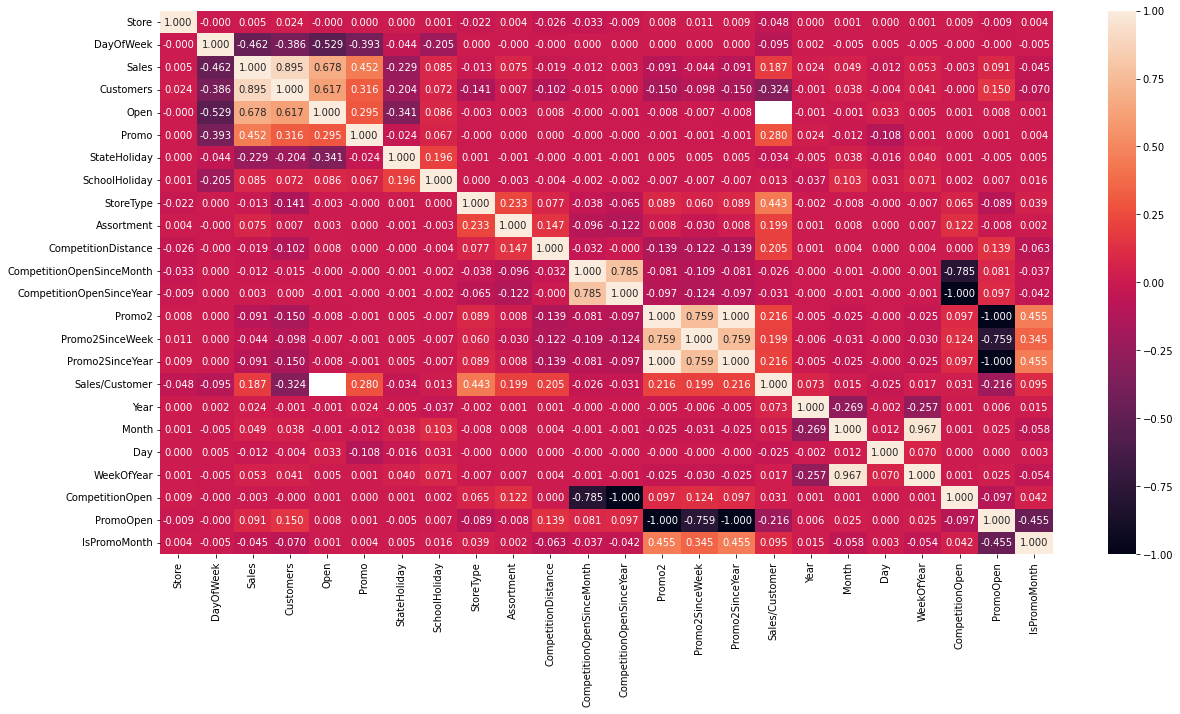

In [25]:
plt.figure(figsize = (20, 10))

sns.heatmap(df_train_store.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')

In [26]:
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,3,...,,9.482883,2015,7,31,31,82.0,24187.75,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1,3,...,,9.194139,2015,7,30,31,82.0,24187.75,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1,3,...,,9.143403,2015,7,29,31,82.0,24187.75,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1,3,...,,8.948214,2015,7,28,31,82.0,24187.75,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1,3,...,,9.970588,2015,7,27,31,82.0,24187.75,Jul,0


In [28]:
final_df = df_train_store

#**Part 3-Model Training  : **